In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('data/jj.csv')
df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


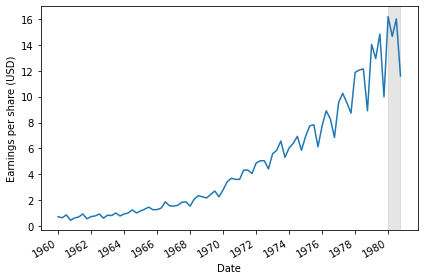

In [3]:
fig, ax = plt.subplots()

ax.plot(df.date, df.data)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

# plt.savefig('figures/CH07_F01_peixeiro.png', dpi=300)

In [4]:
ad_fuller_result = adfuller(df.data)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.742016573457468
p-value: 1.0


In [5]:
eps_diff = np.diff(df.data, n=1)

ad_fuller_result = adfuller(eps_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.407409763638043
p-value: 0.9088542416911309


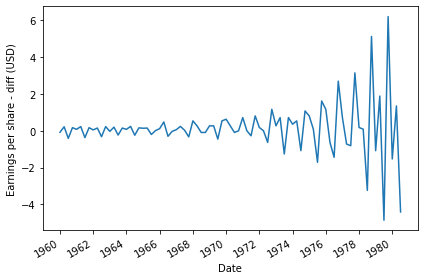

In [6]:
fig, ax = plt.subplots()

ax.plot(df.date[1:], eps_diff)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share - diff (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

# plt.savefig('figures/CH07_F01_peixeiro.png', dpi=300)

In [7]:
eps_log_diff = np.log(df.data).diff().dropna()

ad_fuller_result = adfuller(eps_log_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -4.317043945811822
p-value: 0.00041497314044409007


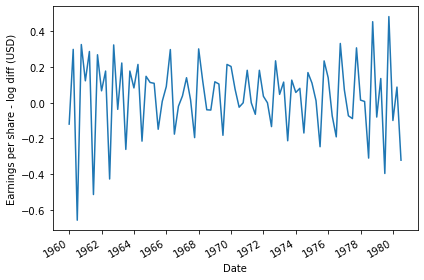

In [8]:
fig, ax = plt.subplots()

ax.plot(df.date[1:], eps_log_diff)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share - log diff (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

# plt.savefig('figures/CH07_F01_peixeiro.png', dpi=300)

In [9]:
df['log_data'] = np.log(df.data)
df.head()

,date,data,log_data
0,1960-01-01,0.71,-0.342490
1,1960-04-01,0.63,-0.462035
2,1960-07-02,0.85,-0.162519
3,1960-10-01,0.44,-0.820981
4,1961-01-01,0.61,-0.494296


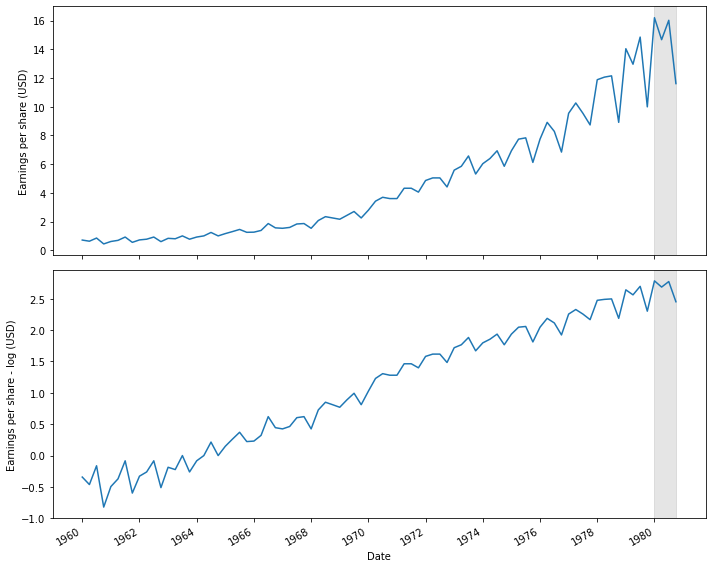

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(df.date, df.data)
ax1.set_xlabel('Date')
ax1.set_ylabel('Earnings per share (USD)')
ax1.axvspan(80, 83, color='#808080', alpha=0.2)

ax2.plot(df.date, df.log_data)
ax2.set_xlabel('Date')
ax2.set_ylabel('Earnings per share - log (USD)')
ax2.axvspan(80, 83, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

# plt.savefig('figures/CH07_F01_peixeiro.png', dpi=300)

In [11]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [12]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 1

order_list = list(product(ps, qs))

In [13]:
train = df.log_data[:-4]

result_df = optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 3)",-108.014772
1,"(3, 2)",-98.962518
2,"(3, 1)",-83.705468
3,"(1, 3)",-66.310165
4,"(3, 0)",-62.453838
5,"(2, 2)",-57.248712
6,"(2, 3)",-55.675622
7,"(0, 3)",-54.742635
8,"(1, 2)",-50.346910
9,"(0, 2)",-46.054734


In [14]:
model = SARIMAX(train, order=(3,1,3), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               log_data   No. Observations:                   80
Model:               SARIMAX(3, 1, 3)   Log Likelihood                  61.007
Date:                Wed, 07 Jul 2021   AIC                           -108.015
Time:                        19:43:06   BIC                            -91.429
Sample:                             0   HQIC                          -101.370
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9971      0.034    -29.162      0.000      -1.064      -0.930
ar.L2         -0.9888      0.035    -28.181      0.000      -1.058      -0.920
ar.L3         -0.9748      0.017    -56.572      0.0

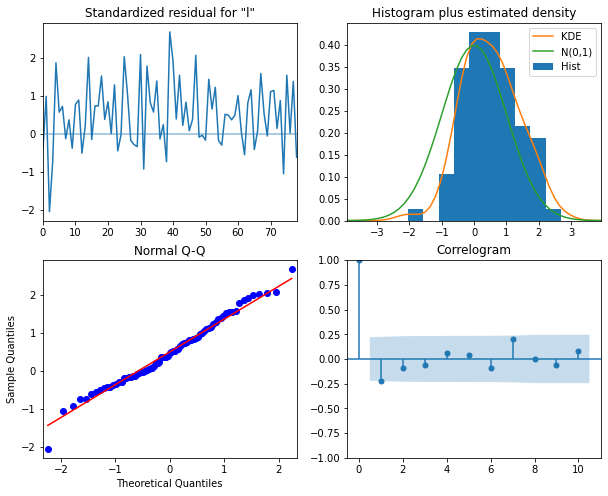

In [15]:
model_fit.plot_diagnostics(figsize=(10,8));

# plt.savefig('figures/CH07_F01_peixeiro.png', dpi=300)

In [16]:
residuals = model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

[0.24493111 0.28453657 0.1701433  0.23355887 0.34831669 0.42983117
 0.34887046 0.45039684 0.54286391 0.51258847]


In [17]:
test = df.iloc[-4:]

test['naive_seasonal'] = df['data'].iloc[76:80].values
test

,date,data,log_data,naive_seasonal
80,1980-01-01,16.20,2.785011,14.04
81,1980-04-01,14.67,2.685805,12.96
82,1980-07-02,16.02,2.773838,14.85
83,1980-10-01,11.61,2.451867,9.99


In [18]:
log_pred = model_fit.get_prediction(80, 83).predicted_mean

test['log_pred'] = log_pred
test

,date,data,log_data,naive_seasonal,log_pred
80,1980-01-01,16.20,2.785011,14.04,2.697691
81,1980-04-01,14.67,2.685805,12.96,2.590306
82,1980-07-02,16.02,2.773838,14.85,2.660636
83,1980-10-01,11.61,2.451867,9.99,2.310587


In [19]:
test['ARIMA_pred'] = np.exp(test.log_pred)
test

,date,data,log_data,naive_seasonal,log_pred,ARIMA_pred
80,1980-01-01,16.20,2.785011,14.04,2.697691,14.845421
81,1980-04-01,14.67,2.685805,12.96,2.590306,13.333856
82,1980-07-02,16.02,2.773838,14.85,2.660636,14.305390
83,1980-10-01,11.61,2.451867,9.99,2.310587,10.080340


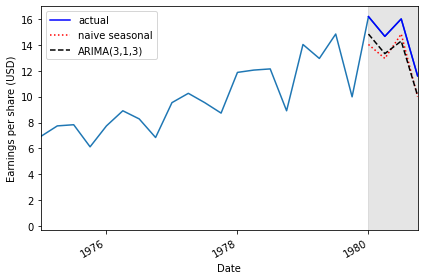

In [25]:
fig, ax = plt.subplots()

ax.plot(df.date, df.data)
ax.plot(test.data, 'b-', label='actual')
ax.plot(test.naive_seasonal, 'r:', label='naive seasonal')
ax.plot(test.ARIMA_pred, 'k--', label='ARIMA(3,1,3)')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax.set_xlim(60, 83)

fig.autofmt_xdate()
plt.tight_layout()

# plt.savefig('figures/CH07_F01_peixeiro.png', dpi=300)

In [26]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [27]:
mape_naive_seasonal = mape(test.data, test.naive_seasonal)
mape_ARIMA = mape(test.data, test.ARIMA_pred)

print(mape_naive_seasonal, mape_ARIMA)

11.561658552433654 10.336974837855099


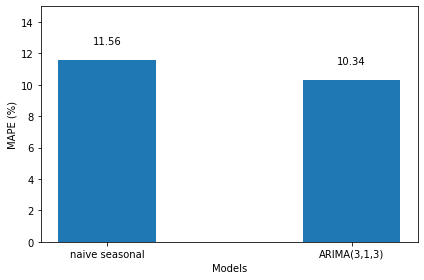

In [30]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(3,1,3)']
y = [mape_naive_seasonal, mape_ARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

# plt.savefig('figures/CH07_F01_peixeiro.png', dpi=300)